In [18]:
import pandas as pd
import numpy as np
import re
import csv
from collections import defaultdict
from collections import Counter
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
word_re = r'\b[a-zA-Z]+\b'
number_re = r'\b[0-9]+\b'
email_re = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
url_re = r'\b(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})\b'

In [4]:
train = pd.read_csv('train.csv')
train.head()

,party_affiliation,email_text,uid_email
0,Democratic Party,⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱...,3083493a6b205eabd8d0f1e7772db09b
1,Democratic Party,This new report needs your attention now. \n ...,3a583e28c820e1fac8902e4df0ef50e0
2,Democratic Party,<PARTY> <ORG> <ORG> <ORG> \n <> NEWS \n <PERS...,044219f46cca419d1d95242dfe036c15
3,Democratic Party,Chip in today to <GPE> to our virtual grassroo...,68059dd1d93d0cbf456763822d1ab680
4,Democratic Party,I ’m really sorry to bother you but I ’m not o...,9f41a878e2839dc013546e615da83efa


In [5]:
def tokenize(text):
    tokens = text.split()
    return tokens

In [6]:
stop_words = []
with open('stop_words.txt', 'rb') as txt:
    lines = txt.readlines()
    stop_words = [str(lines[i], 'utf-8', 'ignore').replace('\n', '') for i in range(len(lines))]

In [7]:
def better_tokenize(text):
    tokens = []
    words = text.split()
    for word in words:
        number = re.search(number_re, word)
        email = re.search(email_re, word)
        url = re.search(url_re, word)
        if number or email or url:
            continue

        match = re.findall(word_re, word)
        if match:
            token = match[0].lower()
            if len(token) == 1 or token in stop_words:
                continue

            tokens.append(token)
    return tokens

In [8]:
dict = defaultdict(int)
for index, row in train.iterrows():   
    tokens = better_tokenize(row[1])
    for token in tokens:
        dict[token] += 1

In [9]:
word_list = []
for key in dict:
    if dict[key] > 9:
        word_list.append(key)

In [10]:
row_ind = []
col_ind = []
data = []
for index, row in train.iterrows():
    tokens = better_tokenize(row[1])
    counter = Counter(tokens)
    for key in counter:
        if key in word_list:
            row_ind.append(index)
            col_ind.append(word_list.index(key))
            data.append(counter[key])

In [11]:
for index, row in train.iterrows():
    row_ind.append(index)
    col_ind.append(len(word_list))
    data.append(1)

In [12]:
mat_coo = sparse.coo_matrix((data, (row_ind, col_ind)))
mat_csc = mat_coo.tocsc() # Xs

In [13]:
y_data = []
y_row_ind = []
y_col_ind = []
for index, row in train.iterrows():
    y_row_ind.append(index)
    y_col_ind.append(0)
    if (row[0] == "Democratic Party"):
        y_data.append(0)
    else:
        y_data.append(1)
y_coo = sparse.coo_matrix((y_data, (y_row_ind, y_col_ind)))
ys = y_coo.tocsc()

In [14]:
def sigmoid(xi, betas):
    return 1 / (1 + np.exp(-np.sum(xi * betas)))

In [15]:
def log_likelihood(ys, xs, betas):
    return np.sum(((ys.transpose()) * (xs * betas))) - np.sum(np.log(1 + np.exp((xs * betas).toarray())))

In [16]:
def compute_gradient(yi, xi, betas):
    return (sigmoid(xi, betas) - np.sum(yi)) * xi.transpose()

In [19]:
def logistic_regrssion(likelihood, betas, ys, xs, learning_rate, num_step):
    likelihood.append(log_likelihood(ys, xs, betas))
    for i in range(num_step):
        betas = betas - learning_rate * compute_gradient(ys[i], xs[i], betas)
        if (i + 1) % 100 == 0:
            likelihood.append(log_likelihood(ys, xs, betas))
            print(log_likelihood(ys, xs, betas))
    return betas

In [20]:
beta_data = np.array([0] * mat_csc.shape[1])
beta_row_ind = np.array(range(max(col_ind)+1))
beta_col_ind = np.array([0] * (max(col_ind)+1))
beta_coo = sparse.coo_matrix((beta_data, (beta_row_ind, beta_col_ind)))
betas = beta_coo.tocsc() # Betas

num_epochs = 1
likelihood = []

for i in range(num_epochs):
    betas = logistic_regrssion(likelihood, betas, ys, mat_csc, 5e-5, 1000)

-35116.111319956115
-33533.00406110851
-32405.96625174861
-31854.96191752349
-31533.91739641488
-31239.595327156036
-31013.48028603598
-30883.506410979353
-30715.636900868536
-30607.37757770734


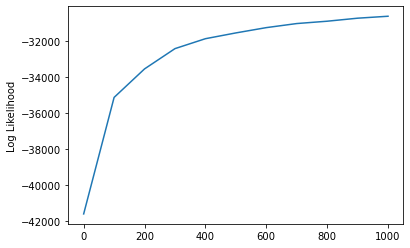

In [44]:
plt.plot([100*i for i in range(11)], likelihood)
plt.ylabel('Log Likelihood')
plt.savefig('Log Likelihood.png', dpi=100, bbox_inches='tight')
plt.show()

In [25]:
with open('betas.txt', 'w') as txt:
    beta_list = betas.transpose().toarray().tolist()[0]
    txt.writelines([str(beta) + '\n' for beta in beta_list])

In [26]:
with open('final_betas.txt', 'r') as txt:
    lines = txt.readlines()
    beta_data = []
    for line in lines:
        line = line.replace('\n', '')
        beta_data.append(float(line))

beta_row_ind = np.array(range(max(col_ind)+1))
beta_col_ind = np.array([0] * (max(col_ind)+1))
beta_coo = sparse.coo_matrix((beta_data, (beta_row_ind, beta_col_ind)))
betas = beta_coo.tocsc() # Betas

In [27]:
test = pd.read_csv('test.csv')
test.head()

,email_text,uid_email
0,"20,000 <GPE> <GPE> signatures needed \n 20,000...",5dfbe09ce5b500dd3dcb9f93c8fb185f
1,We 've worked way too hard and given way too m...,07e48f4183b98420a18503791fb412f6
2,If you use your 800%-MATCH \n <> \n <ORG> <OR...,b58c8607d96a414db0e9cc10108c35f5
3,"<PERSON>, a proposal for Vote- by- <> threaten...",3901d9539d69ada89e5c82e2f1ca950d
4,The <ORG> <ORG> <ORG> is under immediate threa...,6a3e8e6f31381e84a34571deee0f1238


In [28]:
test_row_ind = []
test_col_ind = []
test_data = []
uid = []
for index, row in test.iterrows():
    uid.append(row[1])
    tokens = better_tokenize(row[0])
    counter = Counter(tokens)
    for key in counter:
        if key in word_list:
            test_row_ind.append(index)
            test_col_ind.append(word_list.index(key))
            test_data.append(counter[key])

In [29]:
for index, row in test.iterrows():
    test_row_ind.append(index)
    test_col_ind.append(len(word_list))
    test_data.append(1)

In [30]:
test_mat_coo = sparse.coo_matrix((test_data, (test_row_ind, test_col_ind)))
test_mat_csc = test_mat_coo.tocsc()

In [31]:
def sigmoidAll(xs, betas):
    result = -xs*betas
    np.exp(result.data, out=result.data)
    result.data += 1
    result.data = 1 / result.data
    result.data
    return result

In [32]:
def predict(xs, betas):
    return (sigmoidAll(xs, betas)).toarray()

In [33]:
pred = predict(test_mat_csc, betas)

In [34]:
with open('pred.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['uid_email', 'party_affiliation'])
    for i in range(len(pred)):
        if np.sum(pred[i]) < 0.5:
            csvwriter.writerow([uid[i], 'Democratic Party'])
        else:
            csvwriter.writerow([uid[i], 'Republican Party'])

In [35]:
dev = pd.read_csv('dev.csv')
dev.head()

,party_affiliation,email_text,uid_email
0,Democratic Party,"<> <>, \n <DATE>, <> <PERSON> <PERSON> suspend...",64241625785edfde727dd84c08e5cda2
1,Democratic Party,We simply could not run our campaign without o...,d005af10b61a2565704c237fd506b5e9
2,Democratic Party,I have to give <> <> <PERSON> and the team an ...,75088c6211cca345172d18aab778b93c
3,Democratic Party,"Here ’s your challenge: Can we raise $ 10,000 ...",b56badd20bd35485b7197587333283d1
4,Democratic Party,"This week, I and more than 30 of my colleagues...",f60dc5576465f00970e35e36e57e9f1e


In [36]:
dev_row_ind = []
dev_col_ind = []
dev_data = []
for index, row in dev.iterrows():
    tokens = better_tokenize(row[1])
    counter = Counter(tokens)
    for key in counter:
        if key in word_list:
            dev_row_ind.append(index)
            dev_col_ind.append(word_list.index(key))
            dev_data.append(counter[key])

In [37]:
for index, row in dev.iterrows():
    dev_row_ind.append(index)
    dev_col_ind.append(len(word_list))
    dev_data.append(1)

In [38]:
dev_mat_coo = sparse.coo_matrix((dev_data, (dev_row_ind, dev_col_ind)))
dev_mat_csc = dev_mat_coo.tocsc()

In [39]:
y_dev_data = []
y_dev_row_ind = []
y_dev_col_ind = []
for index, row in dev.iterrows():
    y_dev_row_ind.append(index)
    y_dev_col_ind.append(0)
    if (row[0] == "Democratic Party"):
        y_dev_data.append(0)
    else:
        y_dev_data.append(1)
y_dev_coo = sparse.coo_matrix((y_dev_data, (y_dev_row_ind, y_dev_col_ind)))
ys_dev = y_dev_coo.tocsc()

In [55]:
def eval(ys, xs, betas):
     y_pred = predict(xs, betas)
     y_pred_class = y_pred.round()

     precision = np.sum((y_pred_class + ys) == 0) / np.sum(y_pred_class == 0)
     recall = np.sum((y_pred_class + ys) == 0) / np.sum(ys == 0)
     F1_score = 2 * (precision * recall) / (precision + recall)

     return F1_score

In [56]:
print(eval(ys_dev, dev_mat_csc, betas))

0.9793986636971046


/var/folders/f4/0fh9x3t17c14d2qv0ttjr7_w0000gn/T/ipykernel_83704/2719947209.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  print(eval(ys_dev, dev_mat_csc, betas))
